In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path
from os import path

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
#import data
def import_data(folder_name, file_name): 
    folder_path = './' + folder_name + '/' + file_name
    if path.exists(folder_path):   
        import_data.dataset = pd.read_csv(folder_path,skiprows=2) 
        import_data.dataset = np.array(import_data.dataset) 
        import_data.dataset = import_data.dataset[:-1,:-1] 
        return 1
    
    else:
        return -1

folder_name = 'individual_calib1'
test_folder_name = 'individual_test1'
file_number = 0
no_of_column = 4
FT_training = []   
uSkin_training = [] 
FT_test = []
uSkin_test = []


for i in range(80): 
    file_number += 1
    file_name = 'Position' + str(file_number) + '.txt'    
    if import_data(folder_name, file_name) != -1: 
        #offset with baseline                   
        import_data.dataset [:,8:import_data.dataset.shape[1]] -= import_data.dataset [:,8:import_data.dataset.shape[1]][1,:]
        data_loc = (i % no_of_column) * no_of_column + int(np.fix(i/no_of_column))  #mp.fix Rounds to nearest integer towards zero.
        
        for x in import_data.dataset[:,2:5]:
            FT_training.append(x) 
        for x in  import_data.dataset [:,data_loc*3+8:data_loc*3+11]:
            uSkin_training.append(x)  
    else:
        break 

file_number = 0
for i in range(80):
    file_number += 1
    file_name = 'Position' + str(file_number) + '.txt'    
    if import_data(test_folder_name, file_name) != -1: 
        #offset with baseline        
        import_data.dataset [:,8:import_data.dataset.shape[1]] -= import_data.dataset [:,8:import_data.dataset.shape[1]][1,:]
        data_loc = (i % no_of_column) * no_of_column + int(np.fix(i/no_of_column)) 
        for x in import_data.dataset[:,2:5]:
            FT_test.append(x)
        for x in  import_data.dataset [:,data_loc*3+8:data_loc*3+11]:
            uSkin_test.append(x)  
        
    else:
        break

FT_training = np.array(FT_training)
uSkin_training = np.array(uSkin_training)
FT_test = np.array(FT_test)
uSkin_test = np.array(uSkin_test)

#baseline = uSkin_test[1,:]
#uSkin_test -= baseline

FT_training[:,[0,1]] = FT_training[:,[1,0]] #swap x & y axis
FT_training[:,0:2] *= -1 #rotate x & y axis
FT_test[:,[0,1]] = FT_test[:,[1,0]] #swap x & y axis
FT_test[:,0:2] *= -1 #rotate x & y axis

#normalize uSkin data
max = 65536/ 4 # uSkin is 16 bit, +-x and +-y will be 15-bit each. In reality, the sensor output will never change more than 16,000 digits
FT_max = 10 # One taxel of uSkin typically can only measure up to 5N

uSkin_training /= max
uSkin_test /= max
FT_training /= FT_max


In [5]:
print("Refrence data shape:","Training",FT_training.shape,"Test",FT_test.shape, "\n",
      "uSkin data shape:","Training",uSkin_training.shape,"Test",uSkin_test.shape)

Refrence data shape: Training (441119, 3) Test (121481, 3) 
 uSkin data shape: Training (441119, 3) Test (121481, 3)


In [3]:
# For linear Regression, o/p should be one column
# y1 is x-axis, y2 is y-axis, y3 is Z-axis

y1_train= FT_training[:,0]
y2_train= FT_training[:,1]
y3_train= FT_training[:,2]
y1_test= FT_test[:,0]
y2_test= FT_test[:,1]
y3_test= FT_test[:,2]

In [4]:
y1_train.shape, y2_train.shape, y3_train.shape, y1_test.shape, y2_test.shape, y3_test.shape

((441119,), (441119,), (441119,), (121481,), (121481,), (121481,))

#### Linear Regression 

In [5]:
# Create a model object
from sklearn.linear_model import LinearRegression # least square optimizer
model = LinearRegression(fit_intercept=False,copy_X=True) #the intercept must be false so that when the sensor's value is 0, then the output will be 0 too.

# Loop over targets [y1,y2,y3] for both training and testing 
train_targets=[y1_train,y2_train,y3_train]
test_targets=[y1_test,y2_test,y3_test]
predictions=[]
scores=[]

for t in train_targets:
    model.fit(uSkin_training,t)
    predY= model.predict(uSkin_test)
    predictions.append(predY)
    
predictions=np.array(predictions)
predictions *= FT_max
pred_y1=predictions[0,:]  #using x-axis as target
pred_y2=predictions[1,:]  #using y-axis as target
pred_y3=predictions[2,:]  #using z-axis as target



In [6]:
from sklearn.linear_model import HuberRegressor
Huber = HuberRegressor(epsilon=1.35, max_iter=1000, alpha=0.0001, warm_start=False, fit_intercept=False, tol=1e-05)

Huber_predictions=[]
Huber_scores=[]

for t in train_targets:
    Huber.fit(uSkin_training,t)
    predy= Huber.predict(uSkin_test)
    Huber_predictions.append(predy)

Huber_predictions=np.array(Huber_predictions)
Huber_predictions *= FT_max

Hpred_y1=Huber_predictions[0,:]  #using x-axis as target
Hpred_y2=Huber_predictions[1,:]  #using y-axis as target
Hpred_y3=Huber_predictions[2,:]  #using z-axis as target


#### Performance of LR model with three different targets

#### 1. The Coefficient of Determination

In [8]:
from sklearn.metrics import r2_score
print('R-squared is : ' + str(r2_score(y1_test, pred_y1)))
print('R-squared is : ' + str(r2_score(y2_test, pred_y2)))
print('R-squared is : ' + str(r2_score(y3_test, pred_y3)))

R-squared is : -0.0045366311474110965
R-squared is : 0.0901790783060793
R-squared is : 0.06764373691565295


In [9]:
print('R-squared is : ' + str(r2_score(y1_test, Hpred_y1)))
print('R-squared is : ' + str(r2_score(y2_test, Hpred_y2)))
print('R-squared is : ' + str(r2_score(y3_test, Hpred_y3)))

R-squared is : 0.011864669129055483
R-squared is : 0.07980251503142832
R-squared is : 0.1221078156748473


#### 2. Error Metrics

In [10]:
from sklearn.metrics import mean_absolute_error
print('MAE is : ' + str(mean_absolute_error(y1_test, pred_y1)))
print('MAE is : ' + str(mean_absolute_error(y2_test, pred_y2)))
print('MAE is : ' + str(mean_absolute_error(y3_test, pred_y3)))

MAE is : 0.28126853023355636
MAE is : 0.2625338023622612
MAE is : 0.6582326506313441


In [8]:
from sklearn.metrics import mean_absolute_error
print('MAE is : ' + str(mean_absolute_error(y1_test, pred_y1))+' with standard deviation of ' + str(np.std(y1_test - pred_y1))) 
print('MAE is : ' + str(mean_absolute_error(y2_test, pred_y2))+' with standard deviation of ' + str(np.std(y2_test - pred_y2))) 
print('MAE is : ' + str(mean_absolute_error(y3_test, pred_y3))+' with standard deviation of ' + str(np.std(y3_test - pred_y3))) 


MAE is : 0.28126853023355636 with standard deviation of 0.3015538592750913
MAE is : 0.2625338023622612 with standard deviation of 0.34237158637166837
MAE is : 0.6582326506313441 with standard deviation of 0.3648939607238931


In [11]:
from sklearn.metrics import mean_absolute_error
print('MAE is : ' + str(mean_absolute_error(y1_test, Hpred_y1)))
print('MAE is : ' + str(mean_absolute_error(y2_test, Hpred_y2)))
print('MAE is : ' + str(mean_absolute_error(y3_test, Hpred_y3)))

MAE is : 0.27800475589942136
MAE is : 0.2603447843893112
MAE is : 0.6296901544354572


In [9]:
from sklearn.metrics import mean_absolute_error
print('MAE is : ' + str(mean_absolute_error(y1_test, Hpred_y1))+' with standard deviation of ' + str(np.std(y1_test - Hpred_y1))) 
print('MAE is : ' + str(mean_absolute_error(y2_test, Hpred_y2))+' with standard deviation of ' + str(np.std(y2_test - Hpred_y2))) 
print('MAE is : ' + str(mean_absolute_error(y3_test, Hpred_y3))+' with standard deviation of ' + str(np.std(y3_test - Hpred_y3))) 


MAE is : 0.27800475589942136 with standard deviation of 0.3010878086515868
MAE is : 0.2603447843893112 with standard deviation of 0.3416976463745231
MAE is : 0.6296901544354572 with standard deviation of 0.3705450001540605


#### 3. Correlation between Y and Ŷ

In [11]:
start_range = 1
full_range = len(pred_y1)
end_range = 20000
#end_range = full_range # uncomment to plot everything

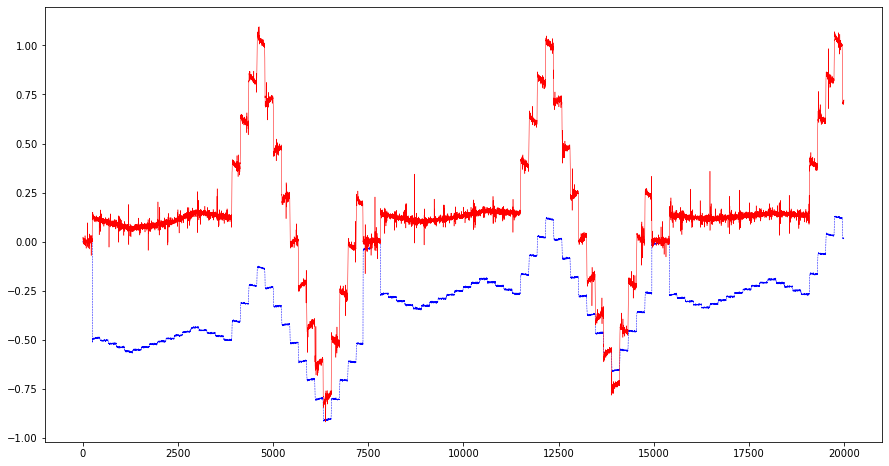

In [12]:
# o/p here is x-axis
plt.figure(figsize=(15,8))
plt.plot(pred_y1[start_range:end_range], "b--", linewidth = 0.5)
plt.plot(y1_test[start_range:end_range], 'r', linewidth = 0.5)

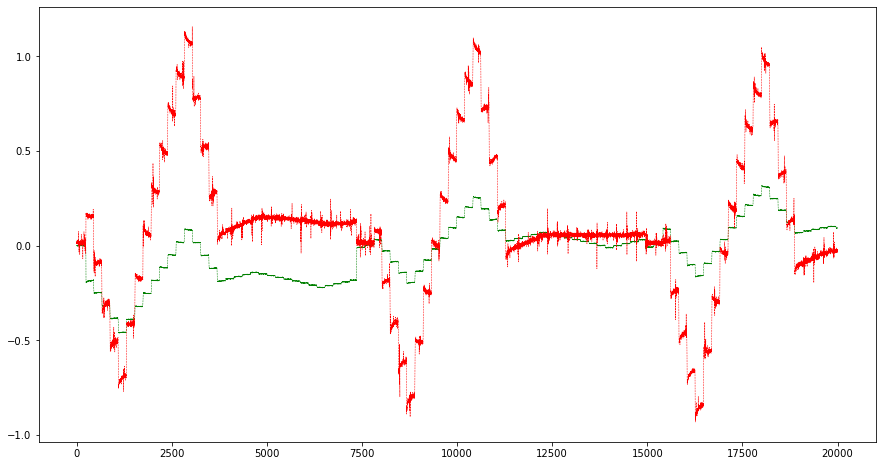

In [13]:
# o/p here is y-axis
plt.figure(figsize=(15,8))
plt.plot(pred_y2[start_range:end_range], "g--", linewidth = 0.5)
plt.plot(y2_test[start_range:end_range], "r--", linewidth = 0.5)

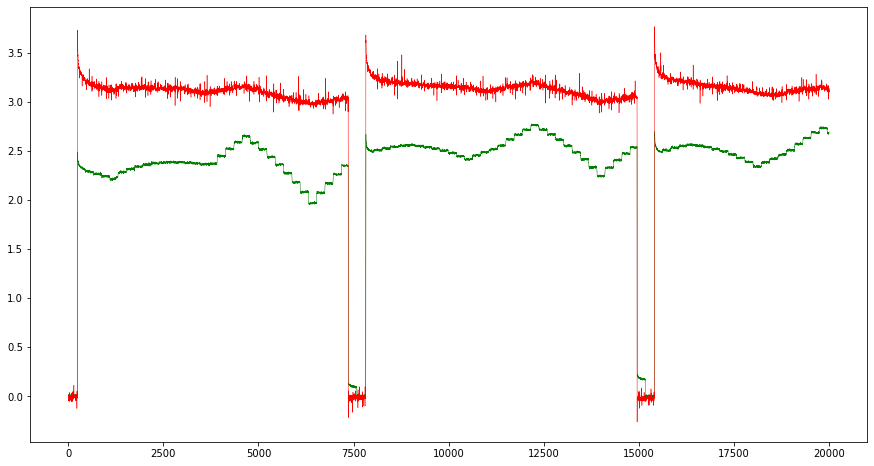

In [14]:
# o/p here is z-axis
plt.figure(figsize=(15,8))
plt.plot(pred_y3[start_range:end_range], 'g', linewidth = 0.5)
plt.plot(y3_test[start_range:end_range], 'r', linewidth = 0.5)

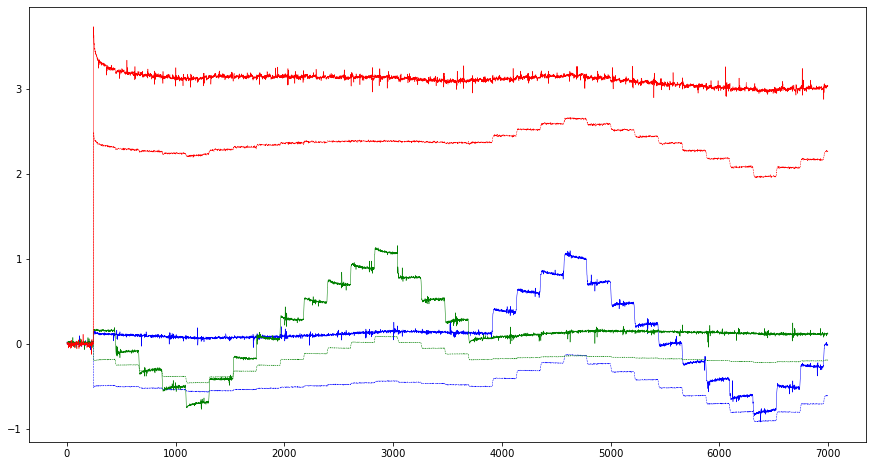

In [26]:
plt.figure(figsize=(15,8))
end_range=7000
plt.plot(pred_y1[start_range:end_range], "b--", linewidth = 0.5)
plt.plot(y1_test[start_range:end_range], 'b', linewidth = 0.5)

plt.plot(pred_y2[start_range:end_range], "g--", linewidth = 0.5)
plt.plot(y2_test[start_range:end_range], "g", linewidth = 0.5)

plt.plot(pred_y3[start_range:end_range], 'r--', linewidth = 0.5)
plt.plot(y3_test[start_range:end_range], 'r', linewidth = 0.5)